In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
import torchvision.transforms

plt.ion()   # interactive mode

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = "C:\\Users\\JBWV9182\\Desktop\\train_vega"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

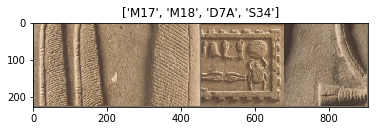

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data
                inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [9]:
import torchvision.models
from torchvision.models.resnet import model_urls

model_urls['resnet18'] = model_urls['resnet18'].replace('https://', 'http://')

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc1 = nn.Linear(num_ftrs, 512)
model_ft.fc2 = nn.Linear(model_ft.fc1.in_features, 256)
model_ft.fc = nn.Linear(model_ft.fc2.in_features, 11) #Add a layer


criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5492 Acc: 0.3333
val Loss: 0.5328 Acc: 0.4324

Epoch 1/24
----------
train Loss: 0.4158 Acc: 0.4028
val Loss: 0.4728 Acc: 0.3784

Epoch 2/24
----------
train Loss: 0.3613 Acc: 0.4722
val Loss: 0.3339 Acc: 0.5676

Epoch 3/24
----------
train Loss: 0.3274 Acc: 0.5556
val Loss: 0.3037 Acc: 0.7027

Epoch 4/24
----------
train Loss: 0.2600 Acc: 0.6667
val Loss: 0.3011 Acc: 0.7027

Epoch 5/24
----------
train Loss: 0.2265 Acc: 0.7083
val Loss: 0.2504 Acc: 0.7297

Epoch 6/24
----------
train Loss: 0.1742 Acc: 0.8056
val Loss: 0.2798 Acc: 0.7568

Epoch 7/24
----------
train Loss: 0.2323 Acc: 0.7222
val Loss: 0.2667 Acc: 0.7568

Epoch 8/24
----------
train Loss: 0.1827 Acc: 0.8333
val Loss: 0.2784 Acc: 0.7568

Epoch 9/24
----------
train Loss: 0.2095 Acc: 0.7361
val Loss: 0.2627 Acc: 0.7568

Epoch 10/24
----------
train Loss: 0.1712 Acc: 0.7917
val Loss: 0.2612 Acc: 0.7568

Epoch 11/24
----------
train Loss: 0.1350 Acc: 0.8611
val Loss: 0.2606 Acc: 0.7568

Ep

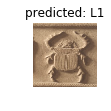

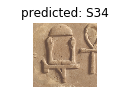

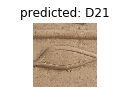

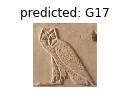

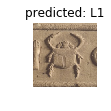

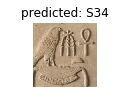

In [12]:
visualize_model(model_ft)

plt.ioff()
plt.show()

In [64]:
imsize = 256
loader = transforms.Compose([transforms.Scale(imsize), transforms.ToTensor()])

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)
    return image

image = image_loader("C:\\Users\\JBWV9182\\Desktop\\train_vega\\test\\P_C_med_W_3 G17_ph.jpg")
model_ft(image)

outputs = model_ft(image)
_, preds = torch.max(outputs.data, 1)

print(class_names[preds[0]])

print(outputs.data)
print(class_names)

L1


Columns 0 to 9 
 0.6136 -0.6437 -1.0528 -1.0039  1.6138  0.5927 -1.8341  1.6711 -1.2659 -1.5653

Columns 10 to 10 
-0.9552
[torch.FloatTensor of size 1x11]

['D21', 'D4', 'D7A', 'D8', 'E34', 'G17', 'H6', 'L1', 'M17', 'M18', 'S34']
